In [1]:
###load Packages##
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgm

%matplotlib inline

In [2]:
###Load Data###
df_train = pd.read_csv("D:/Dropbox/Machine_learning/Projects/Bank_Marketing/bank_additional_full.csv", sep = ";")
df_test = pd.read_csv("D:/Dropbox/Machine_learning/Projects/Bank_Marketing/bank_additional.csv", sep = ";")

In [3]:
###Check basic information###
#df_train.head()
#df_test.head()

In [4]:
###Check basic information###
#df_train.info()
#df_test.info()

In [5]:
###Check basic information###
#df_train.dtypes

In [6]:
###Drop duration due to data leakage###
df_train.drop('duration', axis = 1, inplace = True)
df_test.drop('duration', axis = 1, inplace = True)

In [7]:
###Check missing values###
#df_train.isna().sum()
#df_test.isna().sum()

In [8]:
### Descriptive statistics for numeric variables ###
#df_train.describe()

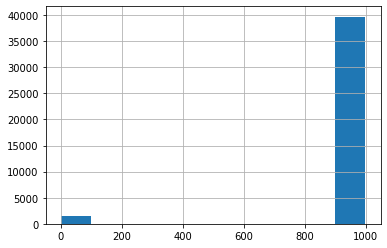

In [9]:
###Check variable pdays###
df_train['pdays'].hist()

In [10]:
###Drop pdays due to large number of missing values###
df_train.loc[df_train['pdays'] == 999, 'pdays'] = "never"
df_train.loc[df_train['pdays'] != 999, 'pdays'] = "before"

In [11]:
###Check missing values of categorical variables###
# var_with_unknown = ['job', 'education', 'marital', 'default', 'housing', 'loan']

# total = df_train.shape[0]
# number = []
# percentage = []

# for col in var_with_unknown:
#     number.append(df_train.loc[df_train[col] == 'unknown', col].count())
#     percentage.append(df_train.loc[df_train[col] == 'unknown', col].count() / total *100)
    
# missing_table = pd.DataFrame({'Name': var_with_unknown, 'Number': number, 'Percentage': percentage})
# missing_table

In [12]:
###Drop unknown values for job and marital due to small amounts (80 and 330)###
df_train = df_train[df_train['job'] != 'unknown']
df_train = df_train[df_train['marital'] != "unknown"]

In [13]:
#df_train.shape

In [14]:
#pd.crosstab(df_train['job'], df_train['education'])

In [15]:
###Impute education by using job ###
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='admin.'), 'education'] = 'university.degree'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='blue-collar'), 'education'] = 'basic.9y'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='entrepreneur'), 'education'] = 'university.degree'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='housemaid'), 'education'] = 'basic.4y'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='management'), 'education'] = 'university.degree'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='retired'), 'education'] = 'basic.4y'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='self-employed'), 'education'] = 'university.degree'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='services'), 'education'] = 'high.school'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='student'), 'education'] = 'high.school'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='technician'), 'education'] = 'professional.course'
df_train.loc[(df_train['education']=='unknown') & (df_train['job']=='unemployed'), 'education'] = 'university.degree'

In [16]:
#pd.crosstab(df_train.job, df_train.housing)

In [17]:
###impute unknown in housing with its mode###
housing_mode = df_train['housing'].mode()
df_train['housing'].replace('unknown', housing_mode[0], inplace = True)
#df_train['housing'].value_counts()

In [18]:
#pd.crosstab(df_train.job, df_train.loan)

In [19]:
###impute unknown in loan with its mode###
loan_mode = df_train['loan'].mode()
df_train['loan'].replace('unknown', loan_mode[0], inplace = True)
#df_train['loan'].value_counts()

In [20]:
dict = {"university.degree": 6,
        "professional.course": 5,
        "high.school": 4,
        "basic.9y": 3,
        "basic.6y": 2,
        "basic.4y": 1,
        "illiterate": 0}

df_train['education'].replace(dict, inplace = True)

In [21]:
### Barplots for categorical variables ###
### job and education ###
# f, axes = plt.subplots(2, 1, figsize=(16, 8))
# sns.barplot(df_train['job'].value_counts().values, df_train['job'].value_counts().index, ax = axes[0])
# axes[0].set_ylabel("Job")
# sns.barplot(df_train['education'].value_counts().values, df_train['education'].value_counts().index, ax = axes[1])
# axes[1].set_ylabel("Education")
# plt.show()

In [22]:
### marital, default, housing, loan, contact, month, day_of_week, poutcome ###
# f, axes = plt.subplots(4, 2, figsize=(16, 16), sharey = False)
# sns.countplot(df_train['marital'], ax = axes[0, 0])
# sns.countplot(df_train['default'], ax = axes[0, 1])
# sns.countplot(df_train['housing'], ax = axes[1, 0])
# sns.countplot(df_train['loan'], ax = axes[1, 1])
# sns.countplot(df_train['month'], ax = axes[2, 0])
# sns.countplot(df_train['day_of_week'], ax = axes[2, 1])
# sns.countplot(df_train['poutcome'], ax = axes[3, 0])     
# plt.show()

In [23]:
### the repsonse variable "y" is unbalanced, use SMOTE###
### convert value yes to 1 and no to 0
df_train['y'].replace({'no':0, 'yes':1}, inplace = True)
target = df_train.pop("y")

In [24]:
# df_train.dtypes

In [25]:
###Seperate data into categorial and numeric###
cat = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays']
num = ['age', 'education', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m',  'nr.employed']

###Convert categorical variables to dummy variables###
df_cat = pd.get_dummies(df_train[cat], drop_first = True)
df_train = pd.concat([df_train, df_cat], axis = 1)
df_train.drop(cat, axis = 1, inplace = True)

###Standardize numerical variables###
SC = StandardScaler()
df_train[num] = SC.fit_transform(df_train[num])

In [26]:
# df_train.shape

In [27]:
# df_train.info()

In [28]:
#df_train.head()

In [29]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 1)
clf.fit(df_train, target)
clf.feature_importances_

array([1.90369909e-01, 6.79834752e-02, 9.18333549e-02, 2.05659366e-02,
       2.78203894e-02, 2.26037092e-02, 2.48309293e-02, 1.21497456e-01,
       6.27469311e-02, 1.31118978e-02, 6.68413464e-03, 4.97145649e-03,
       1.15338509e-02, 7.79961792e-03, 7.44399286e-03, 1.12474173e-02,
       6.46658959e-03, 1.82334674e-02, 6.09650262e-03, 2.02266615e-02,
       1.66907065e-02, 1.56300240e-02, 5.06983381e-07, 4.03175644e-02,
       2.54312480e-02, 1.56500138e-02, 2.09381621e-03, 7.35799874e-04,
       2.28128375e-03, 2.81872151e-03, 4.39172835e-03, 4.86159925e-03,
       1.99009185e-03, 5.93999487e-03, 2.64681069e-03, 1.58340967e-02,
       1.56494176e-02, 1.51114504e-02, 1.61739185e-02, 9.13006978e-03,
       4.25534575e-02])

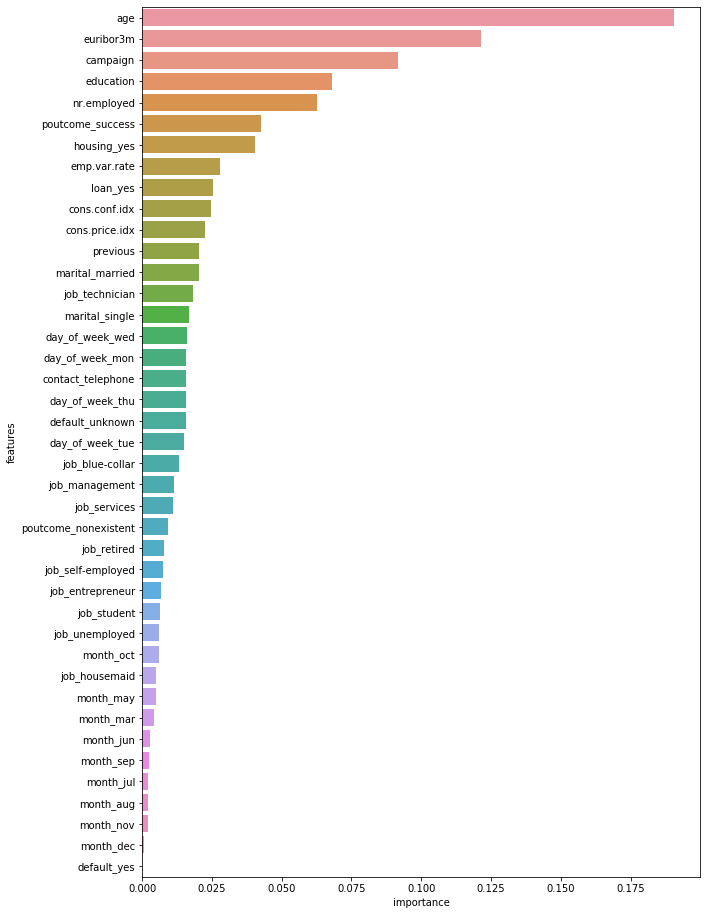

In [30]:
imp = pd.DataFrame(data={'importance':clf.feature_importances_,'features':df_train.columns})
imp = imp.set_index('features')
imp = imp.sort_values('importance',ascending=False)
plt.figure(figsize = (10,16))
sns.barplot(x = imp['importance'], y = imp.index)
plt.show()

In [31]:
# from imblearn.over_sampling import SMOTE
# over_samples = SMOTE(random_state = 1234)
# x_train_smote, y_train_smote = over_samples.fit_sample(df_train, target) 

In [32]:
### Logistic Regression ###
# from sklearn.linear_model import LogisticRegression
# lr = LogisticRegression()
# score = cross_val_score(lr, x_train_smote, y_train_smote, scoring = "roc_auc", cv = 5)
# np.mean(score)

In [33]:
### Support Vector Machine ###
# from sklearn.svm import LinearSVC
# svc = LinearSVC()
# score = cross_val_score(svc, x_train_smote, y_train_smote, scoring = "roc_auc", cv = 5)
# mean(score)

In [34]:
dtrain = xgb.DMatrix(data = df_train, label = target)

In [35]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}
num_round = 2
xgb.cv(param, dtrain, num_round, nfold=5,
       metrics={'error'}, seed=0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

[0]	train-error:0.100547+0.00105664	test-error:0.100547+0.00422711
[1]	train-error:0.10024+0.0011357	test-error:0.100645+0.00410829


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.100547,0.001057,0.100547,0.004227
1,0.100240,0.001136,0.100645,0.004108
